In [1]:
from __future__ import division
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as pl
import statsmodels.api as sm

import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Add file
MTA_Fare = np.load('MTA_Fare.npy')
MTA_Fare.astype(float)
MTA = np.ndarray.flatten(MTA_Fare)
MTA = MTA.astype(float)
MTA[MTA==-1] <- NaN
MTA = np.reshape(MTA,(600, 23, 194))
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [3]:
# Create time range: 194 weeks from 05/21/2010 to 02/21/2014
date = pd.date_range(start='20100521',end='20140221',freq='1W-FRI')[1:195]

In [4]:
# Create data frames: time series per station and time series per ridership type

print (MTA.shape)
#for all stations
mta_stations = np.transpose(np.nansum(MTA, axis=0))
print (mta_stations.shape)
mta_stations = pd.DataFrame(mta_stations,index=date,columns=ridetype).dropna()
#for all ride types
mta_rides = np.transpose(np.nansum(MTA, axis=1))
print (mta_rides.shape)
mta_rides = pd.DataFrame(mta_rides,index=date).dropna()
len(mta_rides)

(600L, 23L, 194L)
(194L, 23L)
(194L, 600L)


194

In [6]:
# Make barplot of means for each type of subscription
#barplot(ridetype,np.nanmean(MTA,axis=0))
MTA.shape

(600L, 23L, 194L)

In [7]:
mta_sta_norm=mta_stations
for col in mta_stations:
    mta_sta_norm[col] = (mta_stations[col] - np.nanmean(mta_stations[col]))/np.nanstd(mta_stations[col])

In [8]:
mta_rides_norm=mta_rides
for col in mta_rides:
    mta_rides_norm[col] = (mta_rides[col] - np.nanmean(mta_rides[col]))/np.nanstd(mta_rides[col])

##Task 1: 
###Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.

In this section I plot the unique average time series accross all variables (ridership type and station), i.e. the mean number of trips per station per ridership type, each week. If this time series is standardized, it is easy to see that there is one big outlier below -3 standard deviations.

C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


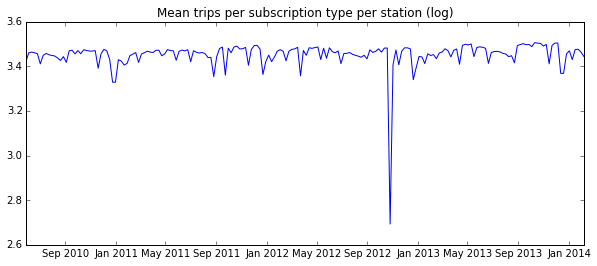

In [9]:
# Plotting the average time series for all stations and all ridership types

mta_mean = np.nanmean(np.nanmean(MTA,axis=1),axis=0)
#plt.plot(date,log10(mta_mean))
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(date,log10(mta_mean))
ax.set_title("Mean trips per subscription type per station (log)")

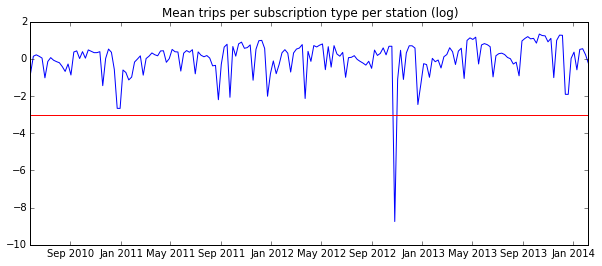

In [10]:
# Visually, it helps to identify the outliers from the normalized curve

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(date,(mta_mean - mta_mean.mean())/mta_mean.std())
ax.set_title("Mean trips per subscription type per station (log)")
plt.axhline(y=-3, xmin=0, xmax=1,c='r')

Now that it has been visually identified that the outlier happened somewhere between September of 2012 and January of 2013, it could be easily identified in the time series.

In [11]:
# Calculate thresholds

thresholds = [np.nanmean(mta_mean) - 3*np.nanstd(mta_mean),
 np.nanmean(mta_mean) + 3*np.nanstd(mta_mean)]
print(thresholds)
ind_thres = (mta_mean<thresholds[0]) | (mta_mean>thresholds[1])
print( "The peak week started in ", date[ind_thres])

[2040.9079118966463, 3656.2460921413867]
('The peak week started in ', DatetimeIndex(['2012-10-26'], dtype='datetime64[ns]', freq='W-FRI', tz=None))


Sandy hit New York City in October the 29th, that is the event we are seeing here.

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

First, let us do a visual inspection

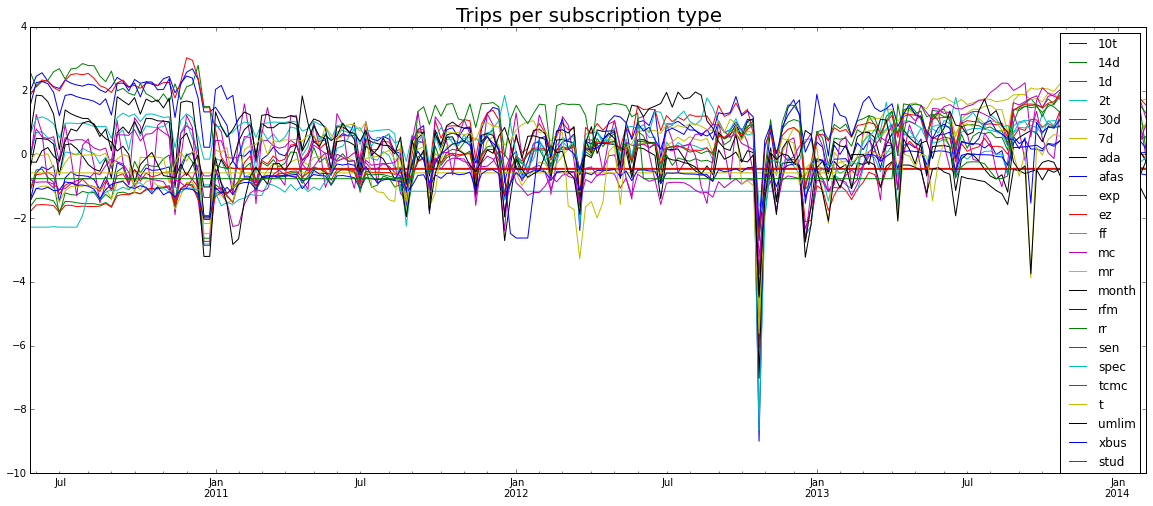

In [12]:
# Plotting trips per subscription type

ax = mta_stations.plot(figsize=(20,8))
ax.set_title("Trips per subscription type", fontsize=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000243B0DD8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000025905B38>], dtype=object)

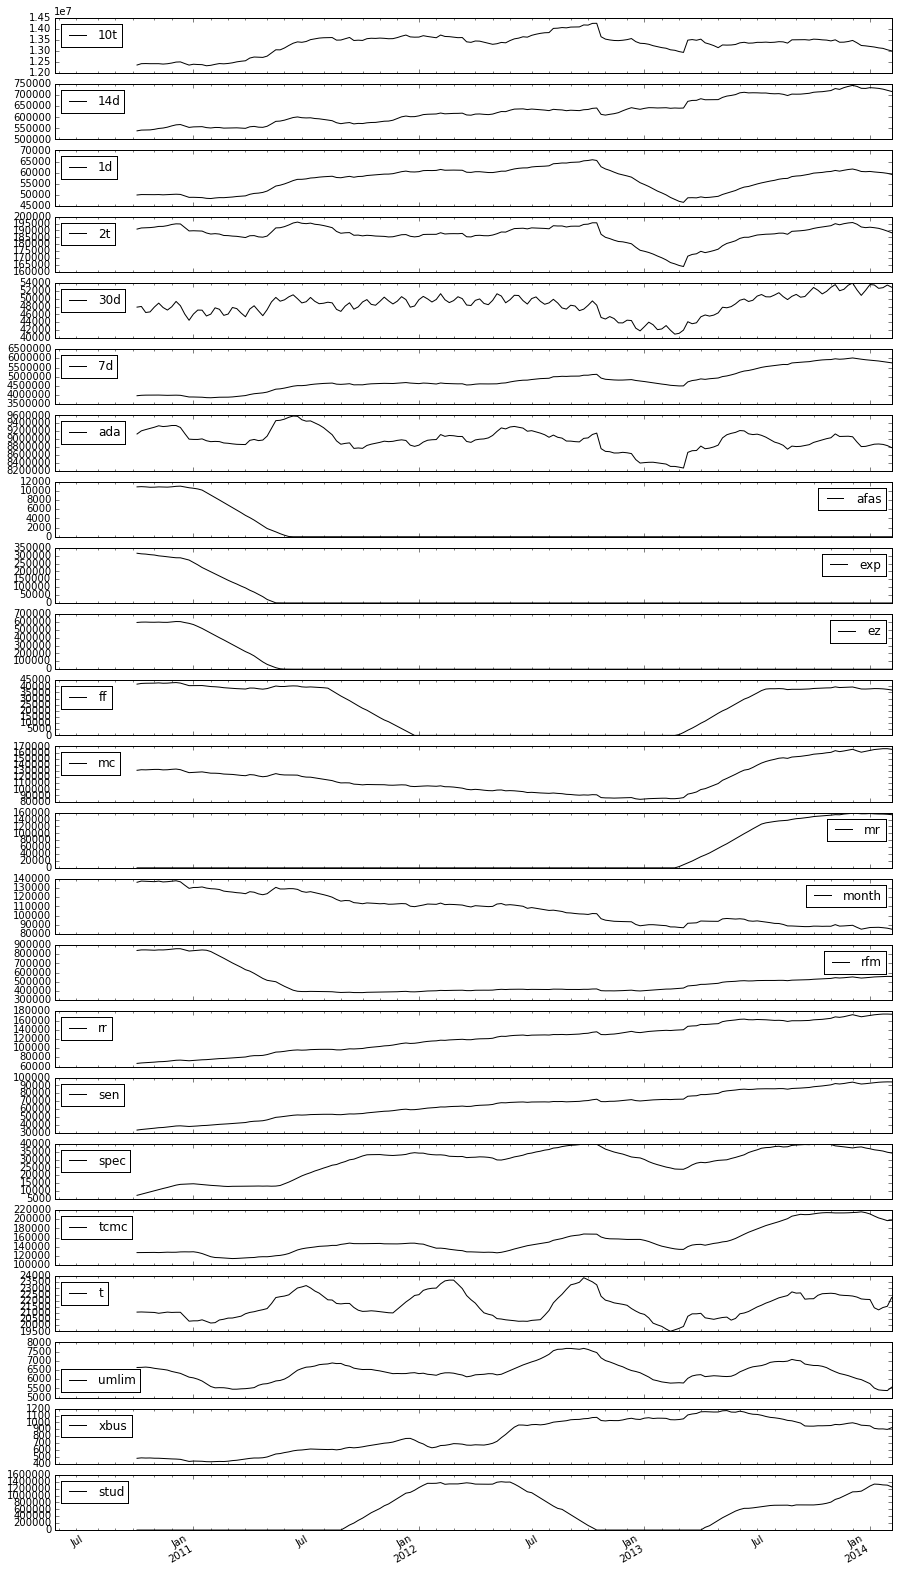

In [13]:
# Rolling mean
mta_stations = np.transpose(np.nansum(MTA, axis=0))
mta_stations = pd.DataFrame(mta_stations,index=date,columns=ridetype).dropna()
pd.rolling_mean((mta_stations),20).plot(figsize=(15,30), subplots=True)

In [14]:
# Difference in fluxes

sta = np.array(mta_stations).shape
flux = [0]*23
i=0
for s in mta_stations:
    try:
        flux[i] = mta_stations[s][184:194].mean()/ mta_stations[s][0:10].mean()
        print ("Type: ",s,". Rate: ",flux[i])
        i+=1
        
    except ZeroDivisionError:
        pass

('Type: ', '10t', '. Rate: ', 1.0217979259493275)
('Type: ', '14d', '. Rate: ', 1.2520650527713835)
('Type: ', '1d', '. Rate: ', 1.111345139872823)
('Type: ', '2t', '. Rate: ', 0.933803359955935)
('Type: ', '30d', '. Rate: ', 1.0337870807111489)
('Type: ', '7d', '. Rate: ', 1.3897476036165586)
('Type: ', 'ada', '. Rate: ', 0.8998413415186712)
('Type: ', 'afas', '. Rate: ', 0.00020944696893810386)
('Type: ', 'exp', '. Rate: ', 1.0687032690411624e-05)
('Type: ', 'ez', '. Rate: ', 1.5019557967733651e-06)
('Type: ', 'ff', '. Rate: ', 0.8188021301712038)
('Type: ', 'mc', '. Rate: ', 1.2135405569957318)
('Type: ', 'mr', '. Rate: ', 24784.93103448276)
('Type: ', 'month', '. Rate: ', 0.5787223845636157)
('Type: ', 'rfm', '. Rate: ', 0.649608431376057)
('Type: ', 'rr', '. Rate: ', 2.592959885919772)
('Type: ', 'sen', '. Rate: ', 2.9093967688393585)
('Type: ', 'spec', '. Rate: ', 70.18237885462555)
('Type: ', 'tcmc', '. Rate: ', 1.5322710626953697)
('Type: ', 't', '. Rate: ', 1.0215890322794365)

By visual inspection, the following "significant" effects were perceived:

### Increase
+ Xbus: express bus
+ tcmec: transit check metrocard
+ spec: special
+ sen: senior citizen
+ rr: rail road
+ mr: mail and ride
+ 7d: 7 day
+ 14d: 14 day

###Decline:
+ rfm: reduced fare media 
+ month: monthly
+ exp: express
+ afas: ada farecard access system
+ ez: easy pay

#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [ ]:
#Applying fourier transform on stations data
f = np.abs(np.fft.rfft(mta_rides))
ffreq = np.fft.rfftfreq(194, d=1.0)
fig = plt.figure(figsize=(10,400))

# Long time
for i in range(600):
    ax = fig.add_subplot(200,3,i)
    f = np.abs(np.fft.rfft(mta_rides[i]))
    ax.set_title("%i" %(i-1))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 8)
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52,c='r')
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

Visual analysis yields that stations 149, 193, 326 and 600 have the biggest annual periodic effect.